In [1]:
import os
import time
import json
import warnings

import h5py
import keras
import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from keras.optimizers import Adam
from keras.utils import plot_model
from matplotlib.image import imread
from keras.preprocessing import image 
from keras.models import Sequential, load_model
from keras.losses import CategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold
from keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

warnings.filterwarnings("ignore")

# Dados

## Explorando dados

In [2]:
# Importando csv do dataset
data = pd.read_csv('dados/train.csv', sep = ',')
data.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [3]:
# Lendo json e crinado mapping para para classe
with open('dados/label_num_to_disease_map.json') as f:
    mapping = json.loads(f.read())
    mapping = {int(k): v for k, v in mapping.items()}

mapping

{0: 'Cassava Bacterial Blight (CBB)',
 1: 'Cassava Brown Streak Disease (CBSD)',
 2: 'Cassava Green Mottle (CGM)',
 3: 'Cassava Mosaic Disease (CMD)',
 4: 'Healthy'}

In [4]:
# Adicionando label_name ao conjunto de dados, e ondenando colunas
data['label_name'] = data['label'].map(mapping)
data = data[['image_id', 'label_name', 'label']]

In [151]:
data.head()

,image_id,label_name,label
0,1000015157.jpg,Cassava Bacterial Blight (CBB),0
1,1000201771.jpg,Cassava Mosaic Disease (CMD),3
2,100042118.jpg,Cassava Brown Streak Disease (CBSD),1
3,1000723321.jpg,Cassava Brown Streak Disease (CBSD),1
4,1000812911.jpg,Cassava Mosaic Disease (CMD),3


In [32]:
data.shape

(21397, 3)

In [53]:
# Verificando frequencia
data.label_name.value_counts()

Cassava Mosaic Disease (CMD)           13158
Healthy                                 2577
Cassava Green Mottle (CGM)              2386
Cassava Brown Streak Disease (CBSD)     2189
Cassava Bacterial Blight (CBB)          1087
Name: label_name, dtype: int64

In [54]:
# Verificando proporção 
data.label_name.value_counts(normalize = True) * 100

Cassava Mosaic Disease (CMD)           61.494602
Healthy                                12.043744
Cassava Green Mottle (CGM)             11.151096
Cassava Brown Streak Disease (CBSD)    10.230406
Cassava Bacterial Blight (CBB)          5.080151
Name: label_name, dtype: float64

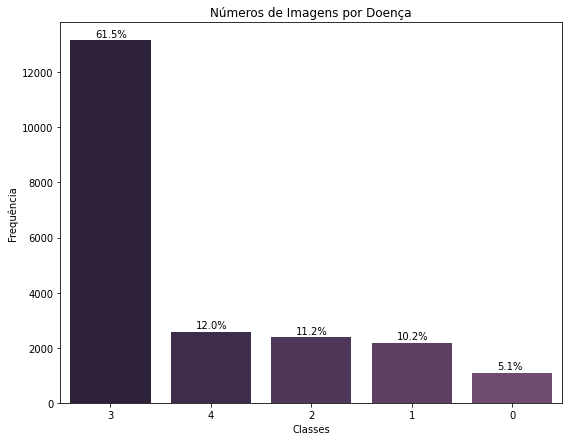

In [150]:
# Plotando quantitativo e percentual das classes
dados = data.label.value_counts().index
palette = sb.cubehelix_palette(15, reverse = True)

plt.figure(figsize = (9, 7))
ax = sb.countplot(x = data.label, order = dados, palette = palette)
plt.title('Números de Imagens por Doença')
plt.xlabel('Classes')
plt.ylabel('Frequência')

for p in ax.patches:
        porcentage = '{:.1f}%'.format((p.get_height() * 100) / data.shape[0])
        x = p.get_x() + 0.25
        y = p.get_height() + 120
        ax.annotate(porcentage, (x, y))

plt.show()

In [142]:
dados = data.label_name.value_counts().sort_values(ascending = False)
bx = sb.barplot(x = dados.values, y = dados.index, palette = palette).set_title('Números de Imagens por Doença')

# Preparando os dados

## HoldOut
Separando dados de treino e teste

In [ ]:
# Definindo paths de treino e teste
TRAIN_PATH = 'dados/train_images/'
TEST_PATH = 'dados/test_images/'
IMAGE_TEST = 'dados/test_images/2216849948.jpg'

In [ ]:
# Criando amostra para treino e teste estrafiticada
train, test = train_test_split(data, test_size = 0.30, shuffle = True, random_state = 0, stratify = data['label_name'])

In [ ]:
# Verificando frequencia do conjunto de trian
train.label_name.value_counts()

Cassava Mosaic Disease (CMD)           9210
Healthy                                1804
Cassava Green Mottle (CGM)             1670
Cassava Brown Streak Disease (CBSD)    1532
Cassava Bacterial Blight (CBB)          761
Name: label_name, dtype: int64

In [ ]:
train.shape

(14977, 3)

In [ ]:
# Verificando frequencia do conjunto de test
test.label_name.value_counts()

Cassava Mosaic Disease (CMD)           3948
Healthy                                 773
Cassava Green Mottle (CGM)              716
Cassava Brown Streak Disease (CBSD)     657
Cassava Bacterial Blight (CBB)          326
Name: label_name, dtype: int64

In [ ]:
test.shape

(6420, 3)

In [ ]:
# Criando conjunto de dados de validação
index = (test.shape[0] - int(test.shape[0] * 0.10))
valid = test.iloc[index:, :]
test = test.iloc[:index - 1, :]
valid.shape, test.shape

((642, 3), (5777, 3))

## Tratamento das imagens
Nossas imagens não estão no formato adequado para usarmos em uma rede neural, usaremos a classe **ImageDataGenerator** com o method **flow_from_dataframe** do keras. Ele irar percorrer nosso cvs e diretório de dados, carregando os dados de imagem e retornar a entrada (matrizes de pixels) e a saída (número inteiro de classe).

## Data Augumentation

É uma técnica para gerar novos exemplares de dados de treinamento a fim de aumentar a generalidade do modelo. Técnicas de aumento de dados, como corte, preenchimento, redimensionamento e rotação, são comumente usadas para treinar grandes redes neurais.

A ideia de manipular imagens decorre de uma premissa básica das atividades que envolvem Deep Learning e a Aprendizagem de Máquina, que é a representatividade da amostra de dados utilizada para treinar um modelo. Quanto maior for a amostra e mais representativos forem os dados utilizados na etapa de treinamento, melhor será o desempenho do modelo ao classificar novos dados. Assim, ao rotacionar as imagens e redimensiona-las, aumentamos nosso espaço amostral gerando uma maior variabilidade de dados, fazendo com que nosso modelo aprenda características apresentadas sob outra "forma".

### Definindo parâmetros para tratamnetos das imagens
Abaixo estamos aumentando nossos dados ao gerar novas imagens a partir das imagens já existentes. Cada parâmetro passado a nossa classe **ImageDataGenerator** altera características das imagens existentes, como zoom, largura, rotação, escala e etc. Um exemplo pode ser visto nas imagens abaixo.

In [ ]:
train_generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest'
)

test_generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
)

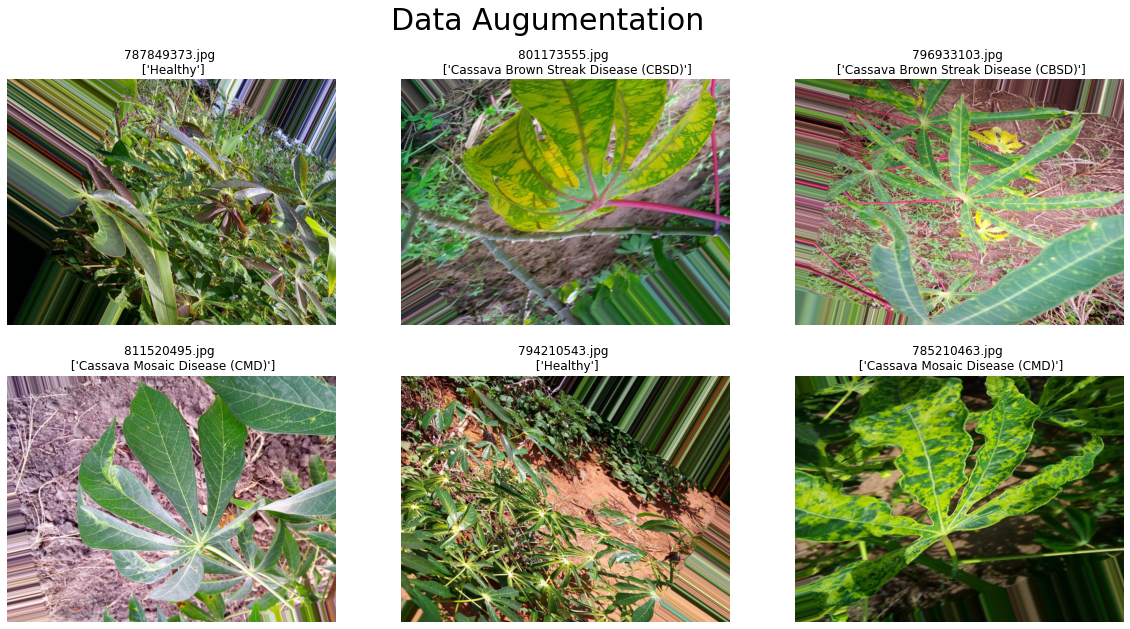

In [ ]:
# Plotando imagens com aumento usando ImageDataGenerator do keras
image_list = os.listdir(TRAIN_PATH)
count = 0

plt.figure(figsize = (20, 10))
for i in image_list:
    img = imread(TRAIN_PATH + i)
    plt.subplot(2, 3, count + 1)
    plt.suptitle("Data Augumentation", fontsize = 30)
    plt.imshow(train_generator.random_transform(img))
    plt.title(f"{i} \n {data.loc[data.image_id == i, 'label_name'].values}")
    plt.axis('off')
    count += 1
    if(count == 6):
        break

In [ ]:
# Definindo conjunto de treino
train_set = train_generator.flow_from_dataframe(
    dataframe = train,
    directory = TRAIN_PATH,
    seed = 42,
    x_col = 'image_id',
    y_col = 'label_name',
    target_size = (456, 456),
    class_mode = 'categorical',
    interpolation = 'nearest',
    shuffle = True,
    batch_size = 15
)

# Definindo conjunto de teste
test_set = test_generator.flow_from_dataframe(
    dataframe = test,
    directory= TRAIN_PATH,
    seed = 42,
    x_col = 'image_id',
    y_col = 'label_name',
    target_size = (456, 456),
    class_mode = 'categorical',
    interpolation = 'nearest',
    shuffle = True,
    batch_size = 15
)

Found 14977 validated image filenames belonging to 5 classes.
Found 5777 validated image filenames belonging to 5 classes.


# Modelo

## Trabalhando hiperparâmetros da rede neural

In [ ]:
# Definindo loss function
loss = CategoricalCrossentropy(from_logits = False, label_smoothing = 0.0001, name = 'categorical_crossentropy')
# Pare de treinar quando o val_loss parar de diminuir por 3 épocas
es = EarlyStopping(monitor = 'val_loss', patience = 3, mode = 'min', restore_best_weights = True, verbose = 1)
# Salve o modelo com o mínimo de perda de validação
checkpoint = ModelCheckpoint(filepath = 'CassavaLeafDiseaseV1.h5', monitor = 'val_loss', save_best_only = True, mode = 'min', verbose = 1)
# Reduza a taxa de aprendizagem quando a aprendizagem estagnar
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 2, min_lr = 1e-6, mode = 'min', verbose = 1)

## EfficientNetB3

In [ ]:
# Criando modelo de rede neural
modelo = Sequential()
modelo.add(EfficientNetB3(input_shape = (456, 456, 3), include_top = False, weights = 'imagenet', drop_connect_rate = 0.6))
modelo.add(GlobalAveragePooling2D())
modelo.add(Flatten())
modelo.add(Dense(256, activation = 'relu', bias_regularizer = tf.keras.regularizers.L1L2(l1 = 0.01, l2 = 0.001)))
modelo.add(Dropout(0.5))
modelo.add(Dense(5, activation = 'softmax'))

43941888/43941136 [==============================] - 1s 0us/step


In [ ]:
# Bloqueando pesos da EfficientNetB3
modelo.layers[0].trainable = True
set_trainable = False

# Desbloqueando pesos da layer block1a_se_excite em diante
for layer in modelo.layers[0].layers:
    if layer.name == 'block1a_se_excite':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
# Compilando rede neural
modelo.compile(optimizer = Adam(lr = 0.001, decay = 0.0001, clipvalue = 0.5), loss = loss, metrics = ['categorical_accuracy'])

In [ ]:
# Informações de parâmetros do modelo 
modelo.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 15, 15, 1536)      10783535  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1536)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               393472    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 1285      
Total params: 11,178,292
Trainable params: 11,090,989
Non-trainable params: 87,303
_____________________________________

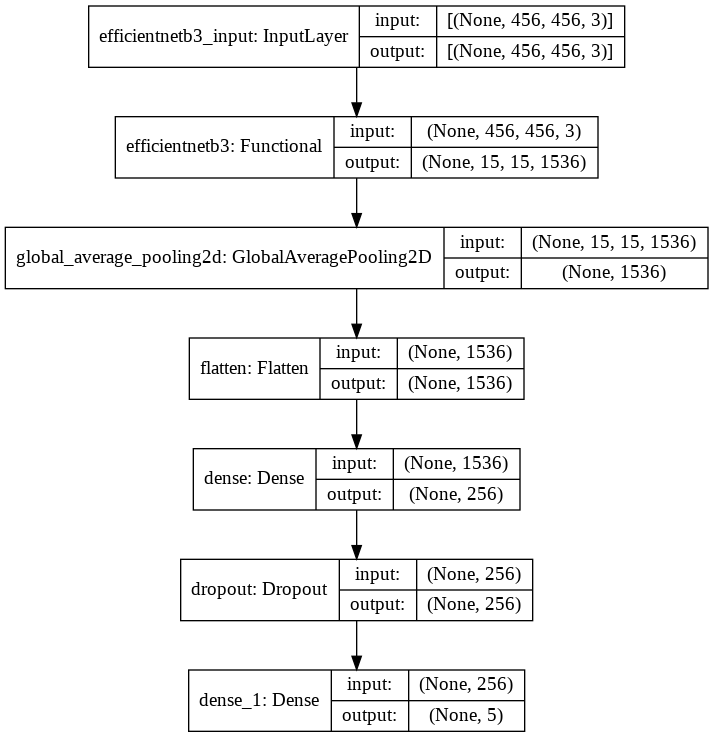

In [ ]:
# Plotando fluxograma do modelo
plot_model(modelo, to_file = 'img/modelo.png',  show_shapes = True)

In [ ]:
# Informações de parâmetros do modelo EfficientNetB3
modelo.layers[0].summary()

In [ ]:
# Plotando fluxograma do modelo EfficientNetB3
plot_model(modelo.layers[0], to_file = 'img/efficientnetb3.png',  show_shapes = True)

## Treinamento e Teste usando Data Augumentation

In [ ]:
# Definindo parâmetros para treino e teste
STEP_SIZE_TRAIN = train_set.n // train_set.batch_size
STEP_SIZE_TEST = test_set.n // test_set.batch_size

# Verificando tempo de execução
inicio = time.time()

# Treinamento e teste do modelo
results = modelo.fit(
    train_set, 
    validation_data = test_set, 
    epochs = 30, 
    batch_size = 10, 
    steps_per_epoch = STEP_SIZE_TRAIN,
    validation_steps = STEP_SIZE_TEST, 
    callbacks = [es, checkpoint, reduce_lr]
)

print()
fim = time.time()
print(fim - inicio)
print()

Epoch 1/30
998/998 [==============================] - 10398s 10s/step - loss: 0.8583 - categorical_accuracy: 0.7097 - val_loss: 0.4748 - val_categorical_accuracy: 0.8377
Epoch 2/30
998/998 [==============================] - 1119s 1s/step - loss: 0.5506 - categorical_accuracy: 0.8169 - val_loss: 0.5200 - val_categorical_accuracy: 0.8305
Epoch 3/30
998/998 [==============================] - 1128s 1s/step - loss: 0.5163 - categorical_accuracy: 0.8287 - val_loss: 0.4584 - val_categorical_accuracy: 0.8345
Epoch 4/30
998/998 [==============================] - 1136s 1s/step - loss: 0.4626 - categorical_accuracy: 0.8480 - val_loss: 0.4080 - val_categorical_accuracy: 0.8606
Epoch 5/30
998/998 [==============================] - 1122s 1s/step - loss: 0.4385 - categorical_accuracy: 0.8540 - val_loss: 0.4216 - val_categorical_accuracy: 0.8630
Epoch 6/30
998/998 [==============================] - 1117s 1s/step - loss: 0.4188 - categorical_accuracy: 0.8657 - val_loss: 0.3923 - val_categorical_accurac

In [ ]:
# Salvando modelo
modelo.save('CassavaLeafDiseaseV1.h5')

## Resultados

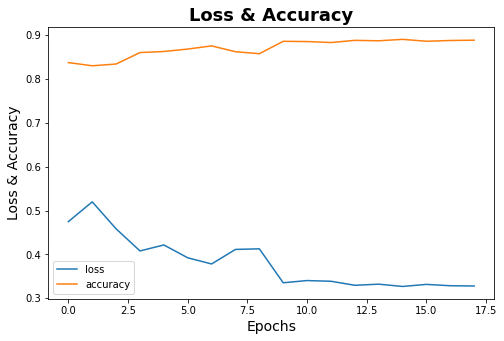

In [ ]:
# Plotando val_loss e val_categorical_accuracy do modelo 
plt.figure(figsize = (8, 5))
plt.plot(results.history['val_loss'])
plt.plot(results.history['val_categorical_accuracy'])
plt.title('Loss & Accuracy', fontweight = 'bold', fontsize = 18)
plt.xlabel('Epochs', fontsize = 14)
plt.ylabel('Loss & Accuracy', fontsize = 14)
plt.legend(title = '', labels = ['loss','accuracy'], ncol = 1, loc = 'lower left')

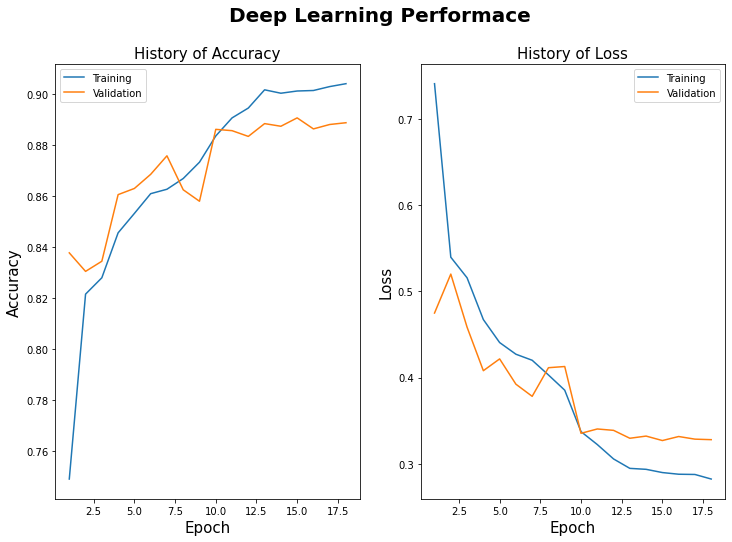

In [ ]:
sca = range(1, len(results.history['categorical_accuracy']) + 1)
sva = range(1, len(results.history['val_categorical_accuracy']) + 1)
slo = range(1, len(results.history['loss']) + 1)
svl = range(1, len(results.history['val_loss']) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 8))
fig.suptitle('Deep Learning Performance', fontweight = 'bold', fontsize = 20)

ax1.plot(sca, results.history['categorical_accuracy'], label = 'Training')
ax1.plot(sva, results.history['val_categorical_accuracy'], label = 'Validation')
ax1.set_title('History of Accuracy', fontsize = 15)
ax1.set_xlabel('Epoch', fontsize = 15)
ax1.set_ylabel('Accuracy', fontsize = 15)
ax1.legend(loc = 'best')

ax2.plot(slo, results.history['loss'], label = 'Training')
ax2.plot(svl, results.history['val_loss'], label = 'Validation')
ax2.set_title('History of Loss', fontsize = 15)
ax2.set_xlabel('Epoch', fontsize = 15)
ax2.set_ylabel('Loss', fontsize = 15)
ax2.legend(loc = 'best')
plt.show()

## Testando Modelo com Validação

In [ ]:
# Realisando classificação no conjunto de validação
def validation_test():
    
    valid_generator = ImageDataGenerator(
        preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
    )    

    valid_set = valid_generator.flow_from_dataframe(
        dataframe = valid,
        directory= TRAIN_PATH,
        seed = 42,
        x_col = 'image_id',
        y_col = 'label_name',
        target_size = (456, 456),
        class_mode = 'categorical',
        interpolation = 'nearest',
        shuffle = True,
        batch_size = 15
    )

    # Accuracy usando keras
    modelo.evaluate(valid_set)

In [ ]:
validation_test()

Found 642 validated image filenames belonging to 5 classes.
43/43 [==============================] - 295s 7s/step - loss: 0.3678 - categorical_accuracy: 0.8863


In [ ]:
# Carregando modelo
leaf_model = load_model('CassavaLeafDiseaseV1.h5')

# Carregando arquivo hdf5 de validação
with h5py.File('dados/valid-456.h5', 'r') as h:
    X_valid = h['image_x_valid'][:]
    y_valid = h['image_y_valid'][:]

X_valid.shape, y_valid.shape

((642, 456, 456, 3), (642, 5))

In [ ]:
previstos = leaf_model.predict(X_valid)
previstos = [np.argmax(t) for t in previstos]
y_valid = [np.argmax(t) for t in y_valid]

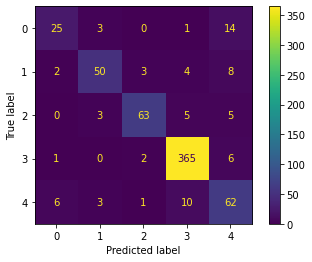

In [ ]:
# Gerando matriz de confusão
matriz = confusion_matrix(y_valid, previstos)
cm_display = ConfusionMatrixDisplay(matriz).plot()

# Validação Cruzda com StratifiedKFold

In [ ]:
# Criando função para rede neural
def criar_rede():
    # Criando modelo de rede neural
    modelo = Sequential()
    modelo.add(EfficientNetB3(input_shape = (456, 456, 3), include_top = False, weights = 'imagenet', drop_connect_rate = 0.6))
    modelo.add(GlobalAveragePooling2D())
    modelo.add(Flatten())
    modelo.add(Dense(256, activation = 'relu', bias_regularizer = tf.keras.regularizers.L1L2(l1 = 0.01, l2 = 0.001)))
    modelo.add(Dropout(0.5))
    modelo.add(Dense(5, activation = 'softmax'))
    # Compilando rede neural
    modelo.compile(optimizer = Adam(lr = 0.001, decay = 0.0001, clipvalue = 0.5), loss = loss, metrics = ['categorical_accuracy'])
    
    return modelo

In [ ]:
# Definindo parâmetros para StratifiedKFold
skf = StratifiedKFold(n_splits = 5, random_state = 1, shuffle = True)

X = data[['image_id']]
y = np.zeros(shape = (data.shape[0], 1))

validation_accuracy = []
validation_loss = []

In [15]:
count = 1

for train_index, test_index in skf.split(X, y):
    
    train_data = data.iloc[train_index]
    test_data = data.iloc[test_index]
    print()

    # Definindo conjunto de treino com base no train_index
    train_set = train_generator.flow_from_dataframe(
        dataframe = train_data,
        directory = TRAIN_PATH,
        seed = 42,
        x_col = 'image_id',
        y_col = 'label_name',
        target_size = (456, 456),
        class_mode = 'categorical',
        interpolation = 'nearest',
        shuffle = True,
        batch_size = 15
    )

    # Definindo conjunto de teste com base no test_index
    test_set = test_generator.flow_from_dataframe(
        dataframe = test_data,
        directory= TRAIN_PATH,
        seed = 42,
        x_col = 'image_id',
        y_col = 'label_name',
        target_size = (456, 456),
        class_mode = 'categorical',
        interpolation = 'nearest',
        shuffle = True,
        batch_size = 15
    )

    # Definindo parada, para aproveitamento dos pesos
    if(count == 1):
      # Criando modelo
      modelo = criar_rede()
      print()
    
    # Verificando tempo de execução
    inicio = time.time()

    # Treinamento e teste do modelo
    history = modelo.fit(train_set, epochs = 12, batch_size = 10)

    print()
    fim = time.time()
    print(fim - inicio)
    print()

    # Testando modelo
    results = modelo.evaluate(test_set)

    # Pegando valores do loss e accuracy das folds
    validation_loss.append(results[0])
    validation_accuracy.append(results[1])
    count += 1


Found 17117 validated image filenames belonging to 5 classes.
Found 4280 validated image filenames belonging to 5 classes.
43941888/43941136 [==============================] - 0s 0us/step

Epoch 1/12
1142/1142 [==============================] - 12330s 11s/step - loss: 0.8535 - categorical_accuracy: 0.7067
Epoch 2/12
1142/1142 [==============================] - 1149s 1s/step - loss: 0.5670 - categorical_accuracy: 0.8120
Epoch 3/12
1142/1142 [==============================] - 1151s 1s/step - loss: 0.4844 - categorical_accuracy: 0.8417
Epoch 4/12
1142/1142 [==============================] - 1152s 1s/step - loss: 0.4606 - categorical_accuracy: 0.8481
Epoch 5/12
1142/1142 [==============================] - 1147s 1s/step - loss: 0.4397 - categorical_accuracy: 0.8537
Epoch 6/12
1142/1142 [==============================] - 1145s 1s/step - loss: 0.4074 - categorical_accuracy: 0.8664
Epoch 7/12
1142/1142 [==============================] - 1153s 1s/step - loss: 0.4190 - categorical_accuracy: 0.8

## Resultados Validação Cruzada

In [27]:
# Salvando modelo validação cruzada
modelo.save('CassavaLeafDiseaseV1_vc.h5')

In [26]:
# Valores de loss
validation_loss

[0.39054933190345764,
 0.32652729749679565,
 0.26293623447418213,
 0.1869903951883316,
 0.15190386772155762]

In [25]:
# Valores de accuracy
validation_accuracy

[0.8733645081520081,
 0.8950934410095215,
 0.911427915096283,
 0.9340967535972595,
 0.9446132183074951]

In [20]:
# Média de loss e accuracy, 5 folds
np.mean(validation_loss), np.mean(validation_accuracy)

(0.26378142535686494, 0.9117191672325134)

In [23]:
# Desvio padrão de loss e accuracy, 5 folds
np.std(validation_loss), np.std(validation_accuracy)

(0.0876599237567778, 0.025808349195815327)

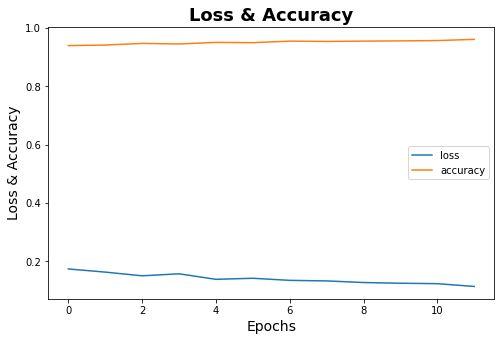

In [34]:
# Plotando loss e categorical_accuracy do modelo 
plt.figure(figsize = (8, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['categorical_accuracy'])
plt.title('Loss & Accuracy', fontweight = 'bold', fontsize = 18)
plt.xlabel('Epochs', fontsize = 14)
plt.ylabel('Loss & Accuracy', fontsize = 14)
plt.legend(title = '', labels = ['loss','accuracy'], ncol = 1, loc = 'best')

## Testando Modelo VC com Validação

In [32]:
# Realisando classificação no conjunto de validação
def validation_test():
    
    valid_generator = ImageDataGenerator(
        preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
    )    

    valid_set = valid_generator.flow_from_dataframe(
        dataframe = valid,
        directory= TRAIN_PATH,
        seed = 42,
        x_col = 'image_id',
        y_col = 'label_name',
        target_size = (456, 456),
        class_mode = 'categorical',
        interpolation = 'nearest',
        shuffle = True,
        batch_size = 15
    )

    # Accuracy usando keras
    modelo.evaluate(valid_set)

In [33]:
validation_test()

Found 642 validated image filenames belonging to 5 classes.
43/43 [==============================] - 9s 199ms/step - loss: 0.0969 - categorical_accuracy: 0.9642


In [2]:
# Carregando modelo
leaf_model = load_model('CassavaLeafDiseaseV1_vc.h5')

# Carregando arquivo hdf5 de validação
with h5py.File('dados/valid-456.h5', 'r') as h:
    X_valid = h['image_x_valid'][:]
    y_valid = h['image_y_valid'][:]

X_valid.shape, y_valid.shape

((642, 456, 456, 3), (642, 5))

In [3]:
previstos = leaf_model.predict(X_valid)
previstos = [np.argmax(t) for t in previstos]
y_valid = [np.argmax(t) for t in y_valid]

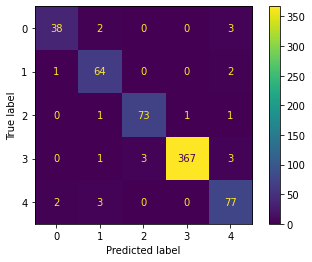

In [4]:
# Gerando matriz de confusão
matriz = confusion_matrix(y_valid, previstos)
cm_display = ConfusionMatrixDisplay(matriz).plot()